In [1]:
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy
import sompylib.sompy as SOM
from time import time
import random
%matplotlib inline


## Loading the data

### Standardizing the coordinates x,y,z

In [2]:
path= './CEM_28_12_Machine_Rotation.csv'
DF = pd.read_csv(path,header=None,sep=',')

In [3]:
ind_false = DF.ix[:,0]==False
ind_false

inds_form = range(1,1261)
form_DF = DF.ix[ind_false,inds_form] #form information

inds_params = range(1261,1289) 

params_DF = DF.ix[ind_false,inds_params] #parameter information

form_DF = form_DF.ix[:,:]
form_DF.shape

(35803, 1260)

In [4]:
DF.shape

(252255, 1290)

In [5]:
Vals_normed  = form_DF.values[:]
for r,points in enumerate(form_DF.values[:]):
    points = points.reshape(21,20,3)
    mx = points.reshape(21*20,3).max(axis=0)
    mn = points.reshape(21*20,3).min(axis=0)
    Vals_normed[r] = ((points-mn)/(mx-mn)).flatten()

In [6]:
Vals_normed.shape

(35803, 1260)

## Form Visualization

In [7]:
which = 100

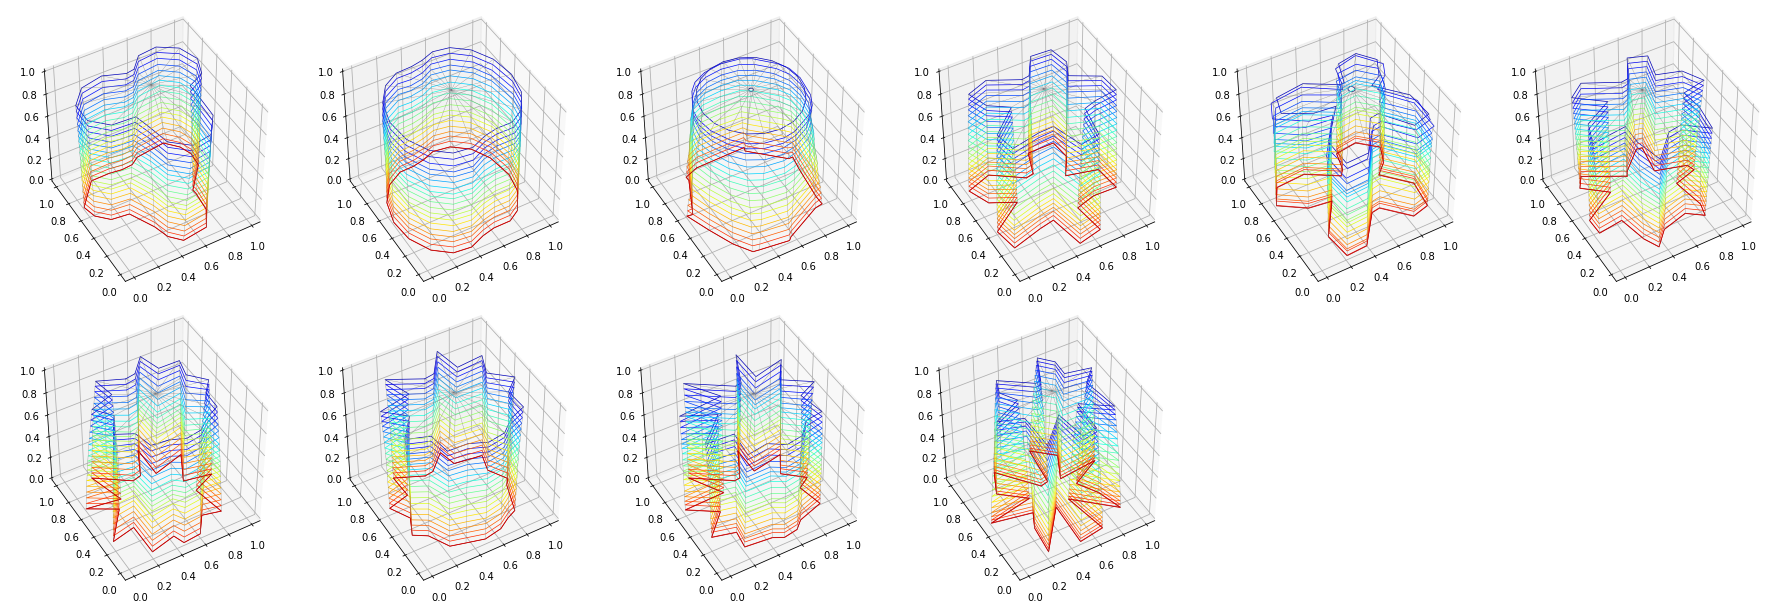

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(25,25))
for kk, f in enumerate(range(which,which+10)):
    coords = Vals_normed[f,:]
    ax = fig.add_subplot(6,6,kk+1, projection='3d')    
    #Horizontal lines in each layer
    coords = coords.reshape(21,20,3)

    for i in range(0,21):        
        ax.plot3D(coords[i,:,0], coords[i,:,1], coords[i,:,2],'-',color=plt.cm.jet(i/21.), linewidth=.7, antialiased=True)
        ax.plot3D(coords[i,[0,19],0], coords[i,[0,19],1],coords[i,[0,19],2],color=plt.cm.jet(i/21.), linewidth=0.7, antialiased=True)
    ax.view_init(45,240)
        
    #Vertical lines in each layer
    coords = coords.flatten().reshape(21*20,3)
    for i in range(20):
            ind = range(i,21*20,20)
            ax.plot3D(coords[ind,0], coords[ind,1], coords[ind,2],'-',color='gray',linewidth=.3, antialiased=True)

plt.tight_layout()
plt.show()

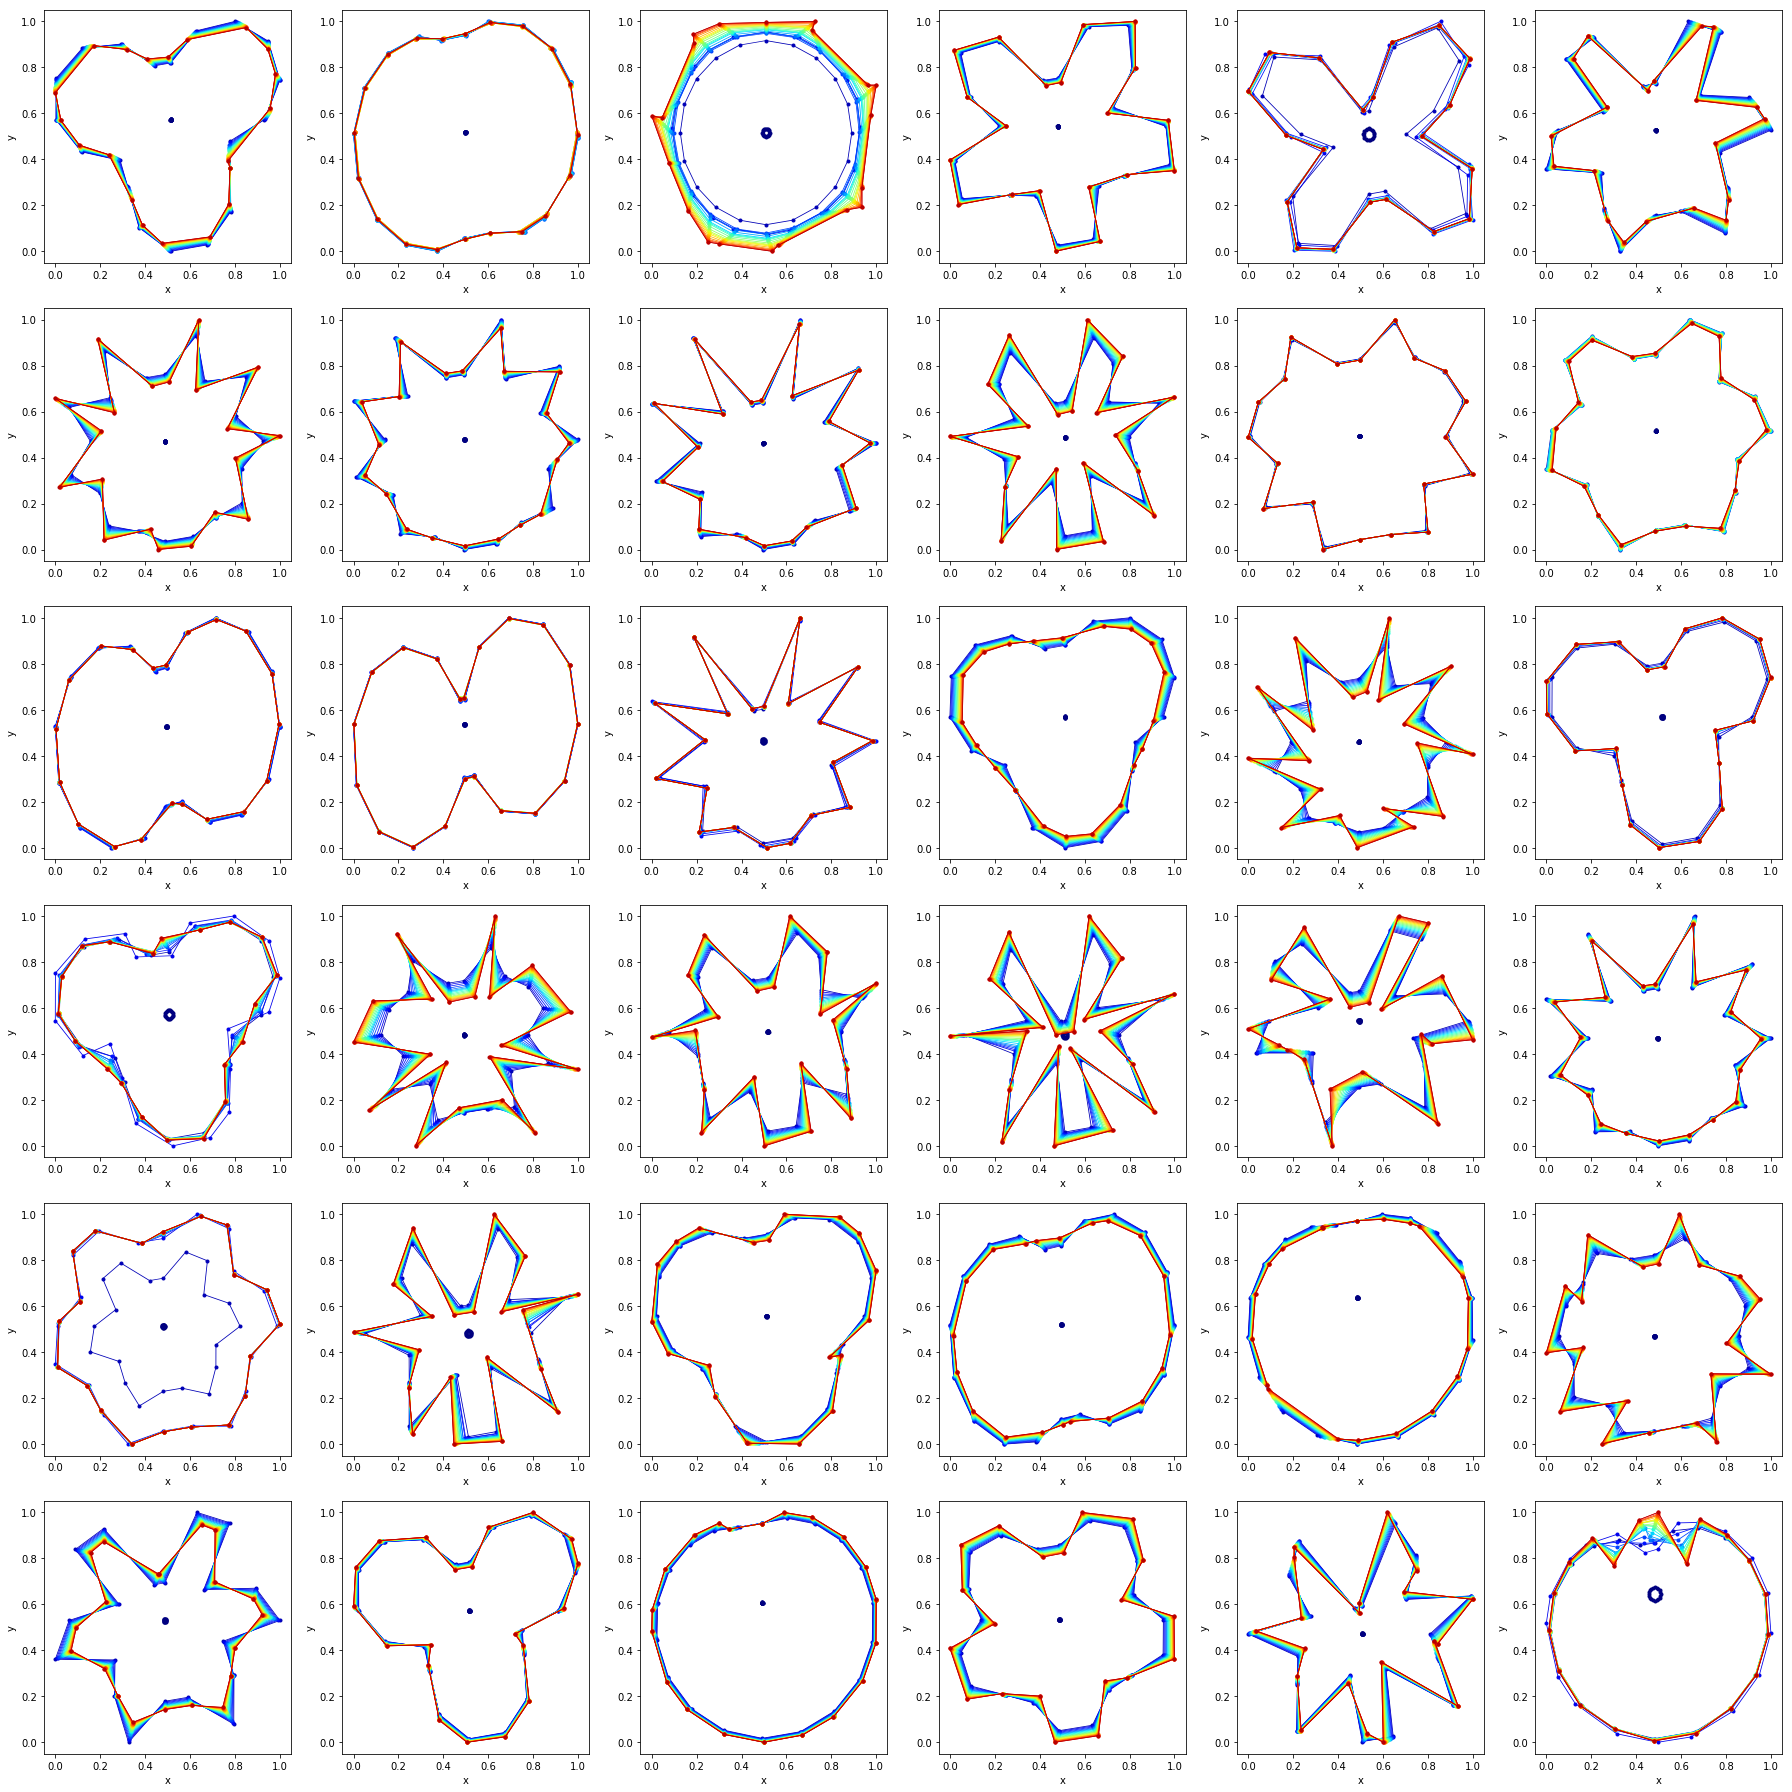

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(25,25))
for kk, f in enumerate(range(which,which+36)):
    coords = Vals_normed[f,:]
    ax = fig.add_subplot(6,6,kk+1)    

    coords = coords.reshape(21,20,3)
    for i in range(0,21):
        ax.plot(coords[i,:,0], coords[i,:,1],'.-',color=plt.cm.jet(i/21.), linewidth=.8, antialiased=True)
        ax.plot(coords[i,[0,19],0], coords[i,[0,19],1],color=plt.cm.jet(i/21.), linewidth=0.7, antialiased=True)

        plt.xlabel('x')
        plt.ylabel('y')

plt.tight_layout()
plt.show()

In [10]:
indkeep = set(range(Vals_normed.shape[1])).difference(set(range(2,Vals_normed.shape[0],3)))
indkeep = list(indkeep)

X = Vals_normed[:,indkeep].astype(float)

## Training a SOM with form data


### Training SOM with x,y,z Coordinates to find similar forms

In [11]:
###############
# Training SOM
###############

import sompylib.sompy as SOM
#definint SOM Size
msz10 = 40
msz11 = 40

som = SOM.SOM('', X[:], mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
som.train(n_job = 1, shared_memory = 'no',verbose='final')

Total time elapsed: 15.433000 secodns
final quantization error: 6.644376


(1356,) 1600


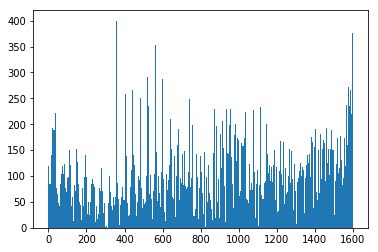

In [12]:
#Printing Best Matching Unit distribution
bmus = som.project_data(som.data_raw)
print (np.unique(bmus).shape, som.nnodes)
plt.hist(bmus,bins=300);

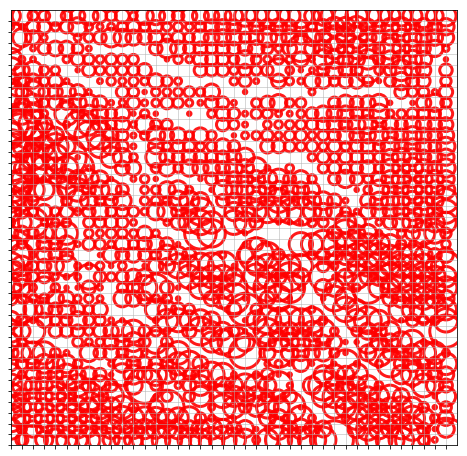

In [13]:
som.hit_map()

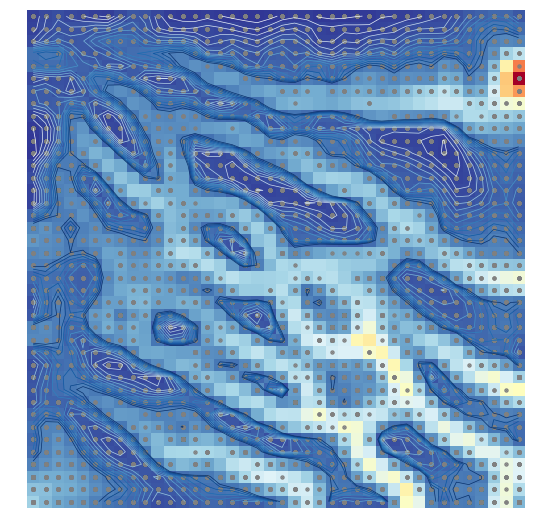

In [14]:
#Visualizing U_matrix
U = som.view_U_matrix(distance2=2, row_normalized='No', show_data='Yes', contooor='Yes', blob='No', save='No', save_dir='')

In [22]:
#Printing the SOM Map
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(120,120))

for bmu in range(som.nnodes):

    cases = np.argwhere(bmus==bmu)
    try:
        
        coords = Vals_normed[cases[0],:]
        ax = fig.add_subplot(som.mapsize[0],som.mapsize[0],bmu+1, projection='3d')    

        coords = coords.reshape(21,20,3)
        for i in range(0,21):        

            ax.plot3D(coords[i,:,0], coords[i,:,1], coords[i,:,2],'-',color=plt.cm.jet(i/21.), linewidth=.7, antialiased=True)
            ax.plot3D(coords[i,[0,19],0], coords[i,[0,19],1],coords[i,[0,19],2],color=plt.cm.jet(i/21.), linewidth=0.7, antialiased=True)                
        coords = coords.flatten().reshape(21*20,3)
        for i in range(20):
            ind = range(i,21*20,20)
            ax.plot3D(coords[ind,0], coords[ind,1], coords[ind,2],'-',color=plt.cm.jet(.1),linewidth=.3, antialiased=True)

        
        ax.view_init(45,240)
        plt.axis('off')
        if bmu%100==0:
            print (bmu)
    except:
        continue
plt.tight_layout(h_pad=.0001, w_pad=.0001 )

fig.savefig('./SOM_MAP'+str(som.mapsize[0])+'_'+str(som.mapsize[0])+'.png',dpi=200)
plt.close()

0
100
200
400
500
600
700
800
1000
1100
1200
1400
1500


In [21]:
#Printing all bmus for one node in the Map

from mpl_toolkits.mplot3d import Axes3D
bmu = 0

for bmu in range(0,10,10):

    fig = plt.figure(figsize=(25,25))

    cases = np.argwhere(bmus==bmu)

    for f in range(36):
        try:
            coords = Vals_normed[cases[f],:]
            ax = fig.add_subplot(6,6,f+1, projection='3d')    
            coords = coords.reshape(21,20,3)
            for i in range(0,21):
                ax.plot3D(coords[i,:,0], coords[i,:,1], coords[i,:,2],'-',color=plt.cm.jet(i/21.), linewidth=.7, antialiased=True)
                ax.plot3D(coords[i,[0,19],0], coords[i,[0,19],1],coords[i,[0,19],2],color=plt.cm.jet(i/21.), linewidth=0.7, antialiased=True)

            coords = coords.flatten().reshape(21*20,3)
            for i in range(20):
                ind = range(i,21*20,20)
                ax.plot3D(coords[ind,0], coords[ind,1], coords[ind,2],'-',color='gray',linewidth=.3, antialiased=True)

            ax.view_init(45,240)
        except:
            continue
    plt.tight_layout()
    fig.savefig('./images_SOM'+str(bmu)+'.png',dpi=200)
    plt.close()
    print (bmu)

0


# UMAP

In [11]:
import umap
embedding = umap.UMAP(n_components=2).fit_transform(X)

Text(0.5,1,'U-MAP')

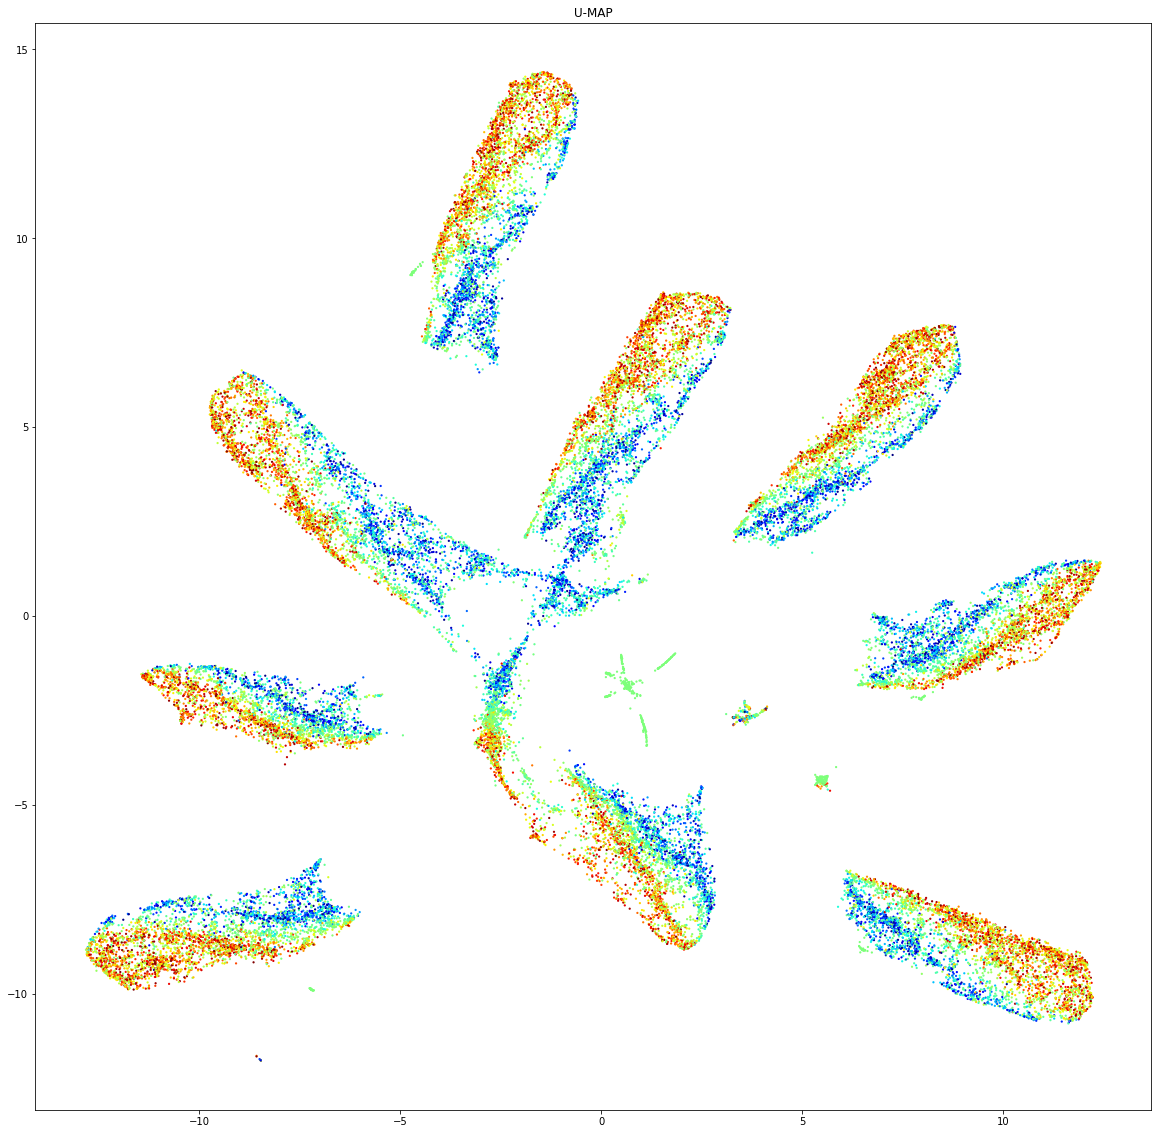

In [18]:
fig = plt.figure(figsize=(20,20))
#plt.plot(embedding[:,0],embedding[:,1],'.');
col =1261 #Param AH
#col =1262 #Param BH
#col =1263 #Param CH
#col =1264 #Param AA
#col =1265 #Param AB
#col =1266 #Param AC
#col =1267 #Param BA
#col =1268 #Param BB
#col =1269 #Param BC
#col =1270 #Param CA
#col =1271 #Param CB
#col =1272 #Param CC
#col =1273 #Param L
#col =1274 #Param EE
#col =1275 #Param FE
#col =1276 #Param GE
#col =1277 #Param E
#col =1278 #Param F
#col =1279 #Param G
#col =1285 #Param R
plt.scatter(embedding[:,0],embedding[:,1],s=5,c=params_DF.ix[:,col].values[:].astype(float),cmap=plt.cm.jet,edgecolor='None',marker='o',alpha=1.);
plt.title('U-MAP')

In [19]:
columns = params_DF.columns.values[:]

std = params_DF.describe().ix['std']
std_zero = np.where(std<=0)[0]
std_zero

indNan  = np.where(params_DF.values[:]=='None')
col_nan = np.unique(indNan[1])

remove_cols =  list(std_zero)+list(col_nan)
columns[remove_cols]

sel_cols = list(set(params_DF.columns.values[:]).difference(columns[remove_cols]))
params_DF[sel_cols].shape

(28,)
[20, 21, 25, 26]
[1280, 1283, 1284, 1285, 1288, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279]


(35803, 24)

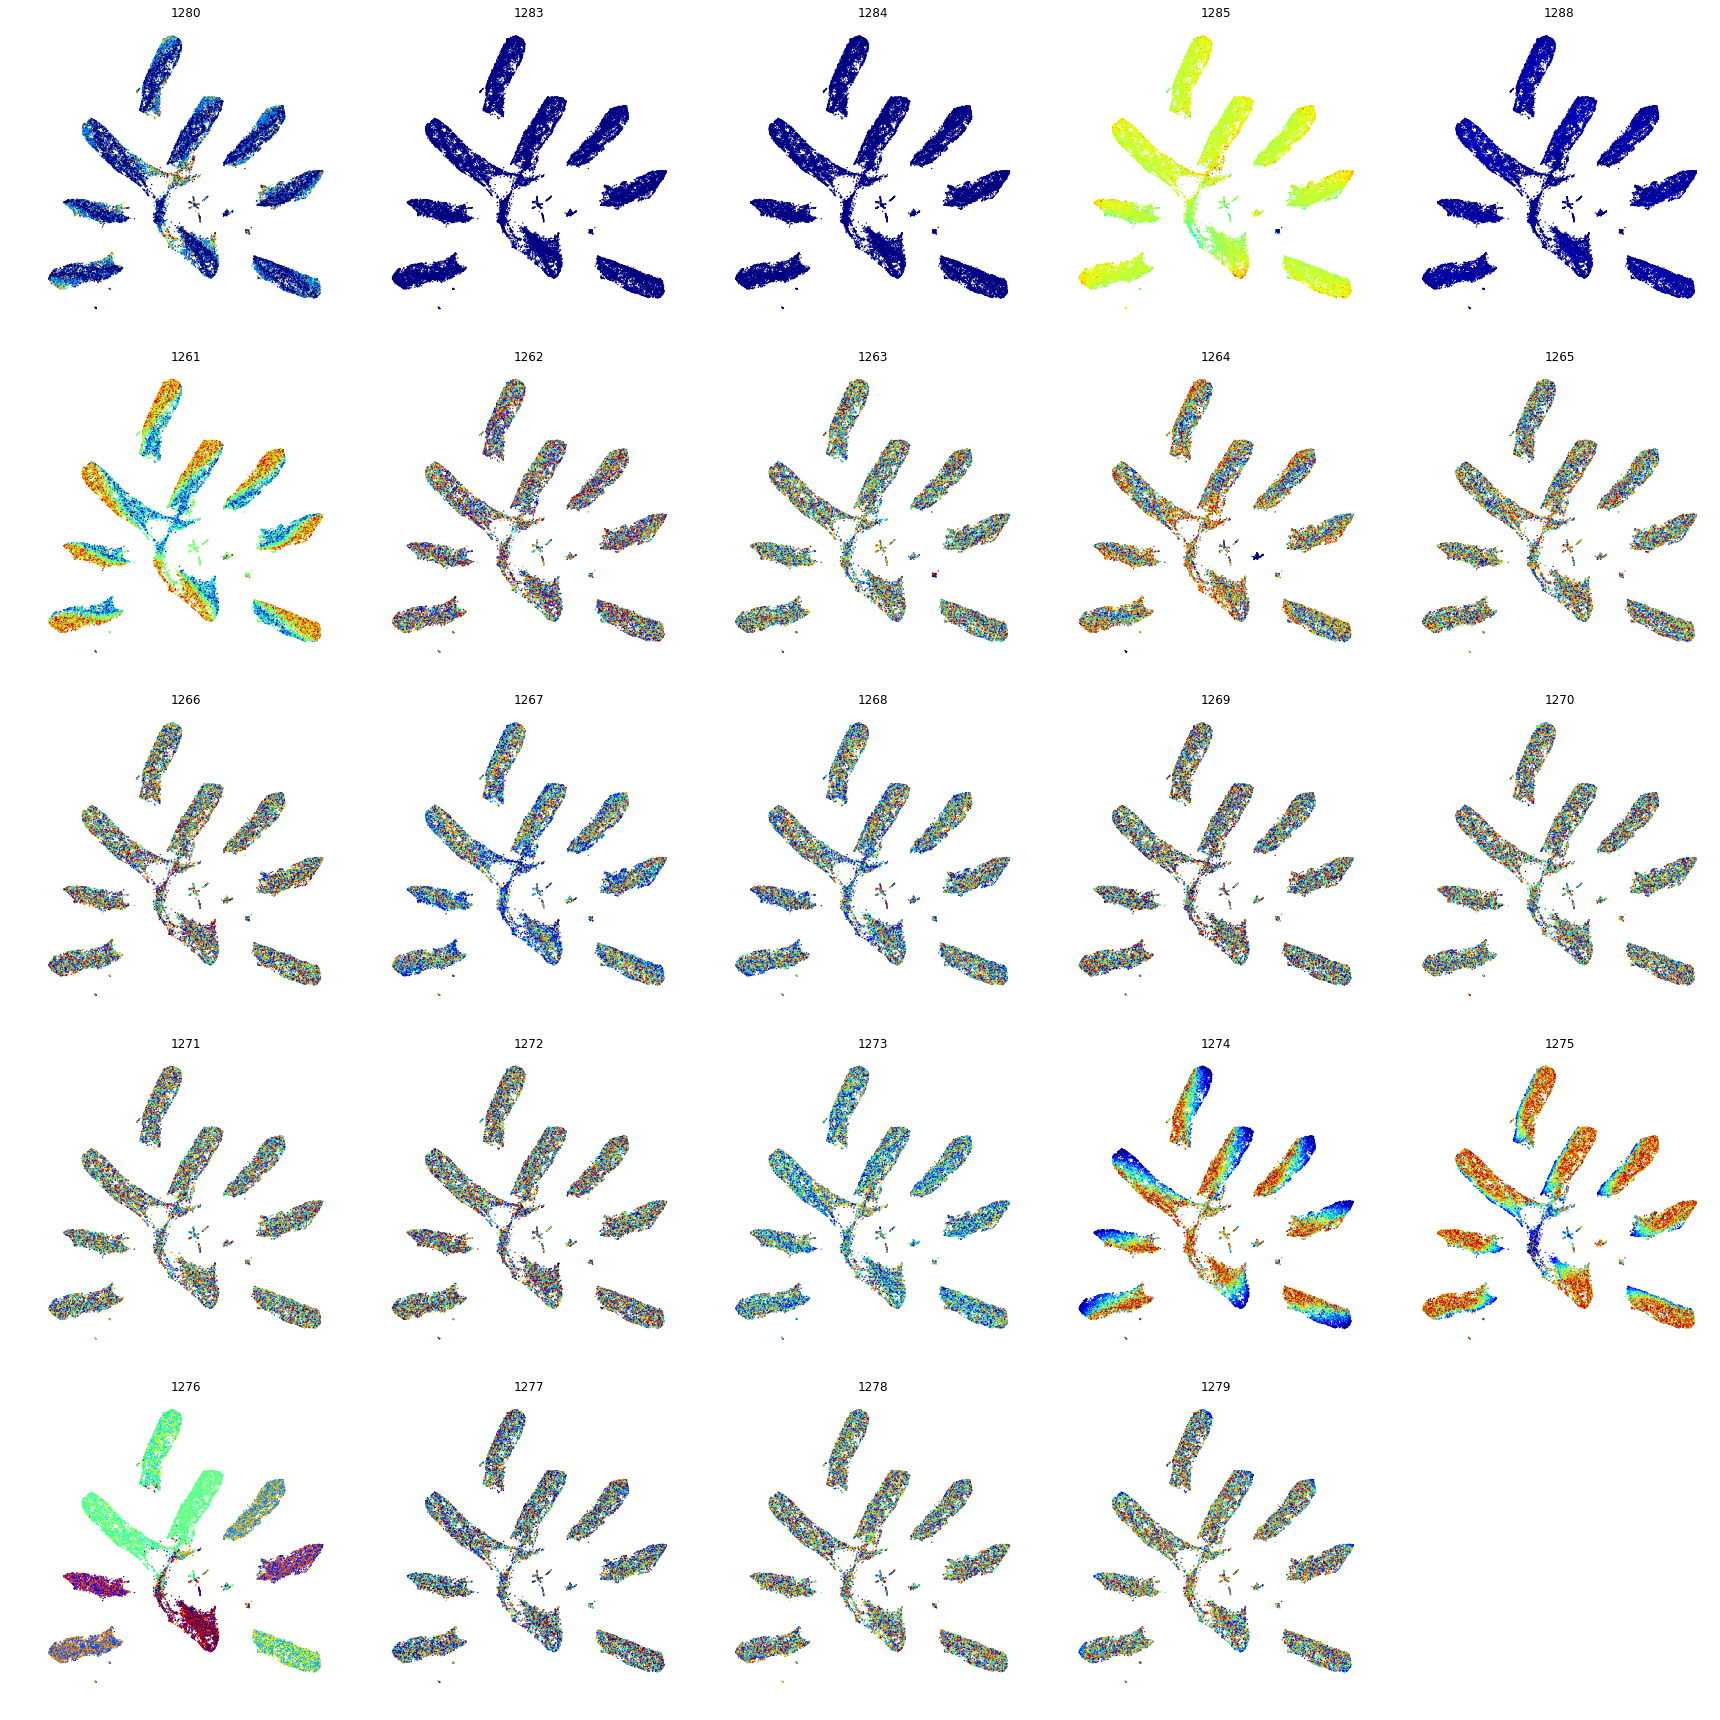

In [20]:

fig = plt.figure(figsize=(24,24))
data = embedding.copy()
for i,col in enumerate(params_DF[sel_cols].columns[:]):    
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.scatter(data[:,0],data[:,1],s=2,c=params_DF.ix[:,col].values[:].astype(float),cmap=plt.cm.jet,edgecolor='None',marker='o',alpha=1.);
    plt.title(col)
plt.tight_layout()